In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('all')
from nltk.sentiment import SentimentIntensityAnalyzer

from tqdm.notebook import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline 
from scipy.special import softmax

import torch



[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/useradmin/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/useradmin/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/useradmin/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/useradmin/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/useradmin/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloadi

In [2]:
df = pd.read_csv('global-warming.csv')

In [3]:
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


## EDA

In [4]:
df.shape

(15819, 3)

In [5]:
df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.dtypes

sentiment     int64
message      object
tweetid       int64
dtype: object

In [8]:
df.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


In [9]:
df['tweetid'].nunique()

15819

Text(0, 0.5, 'Count')

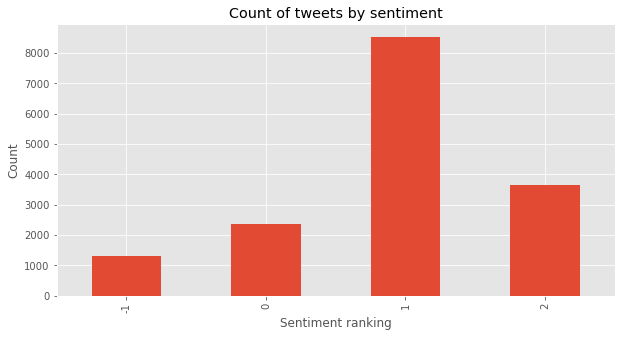

In [10]:
ax = df['sentiment'].value_counts().sort_index().plot(kind='bar', title='Count of tweets by sentiment',
                                                figsize=(10,5))
ax.set_xlabel('Sentiment ranking')
ax.set_ylabel('Count')

## NLTK

In [11]:
example = df['message'][52]
print(example)

Chris: Who is it then that initially talked about climate change?
Me: * thinked for three seconds * ... The EuropeaÃ¢â‚¬Â¦ https://t.co/VwlQICy0H0


In [12]:
toekens = nltk.word_tokenize(example)
print(toekens)

['Chris', ':', 'Who', 'is', 'it', 'then', 'that', 'initially', 'talked', 'about', 'climate', 'change', '?', 'Me', ':', '*', 'thinked', 'for', 'three', 'seconds', '*', '...', 'The', 'EuropeaÃ¢â‚¬Â¦', 'https', ':', '//t.co/VwlQICy0H0']


In [13]:
tagged = nltk.pos_tag(toekens)
print(tagged)

[('Chris', 'NN'), (':', ':'), ('Who', 'WP'), ('is', 'VBZ'), ('it', 'PRP'), ('then', 'RB'), ('that', 'IN'), ('initially', 'RB'), ('talked', 'VBD'), ('about', 'IN'), ('climate', 'NN'), ('change', 'NN'), ('?', '.'), ('Me', 'NN'), (':', ':'), ('*', 'NN'), ('thinked', 'VBD'), ('for', 'IN'), ('three', 'CD'), ('seconds', 'NNS'), ('*', 'VBP'), ('...', ':'), ('The', 'DT'), ('EuropeaÃ¢â‚¬Â¦', 'NNP'), ('https', 'NN'), (':', ':'), ('//t.co/VwlQICy0H0', 'NN')]


In [14]:
entities = nltk.chunk.ne_chunk(tagged)
print(entities)

(S
  (GPE Chris/NN)
  :/:
  Who/WP
  is/VBZ
  it/PRP
  then/RB
  that/IN
  initially/RB
  talked/VBD
  about/IN
  climate/NN
  change/NN
  ?/.
  Me/NN
  :/:
  */NN
  thinked/VBD
  for/IN
  three/CD
  seconds/NNS
  */VBP
  .../:
  The/DT
  EuropeaÃ¢â‚¬Â¦/NNP
  https/NN
  :/:
  //t.co/VwlQICy0H0/NN)


In [15]:
sia = SentimentIntensityAnalyzer()

In [16]:
sia.polarity_scores('South Africa is a poor country')

{'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'compound': -0.4767}

In [17]:
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['message']
    myid = row['tweetid']
    results[myid] = sia.polarity_scores(text)

  0%|          | 0/15819 [00:00<?, ?it/s]

In [18]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index':'tweetid'})
vaders = vaders.merge(df, how='left')
vaders.head()

,tweetid,neg,neu,pos,compound,sentiment,message
0,625221,0.000,0.905,0.095,0.2244,1,PolySciMajor EPA chief doesn't think carbon di...
1,126103,0.167,0.552,0.281,0.1159,1,It's not like we lack evidence of anthropogeni...
2,698562,0.000,1.000,0.000,0.0000,2,RT @RawStory: Researchers say we have three ye...
3,573736,0.245,0.755,0.000,-0.5994,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
4,466954,0.299,0.701,0.000,-0.7506,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


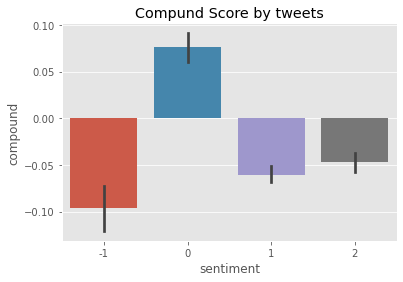

In [19]:
ax = sns.barplot(data=vaders, x ='sentiment', y='compound')
ax.set_title('Compund Score by tweets')
plt.show()

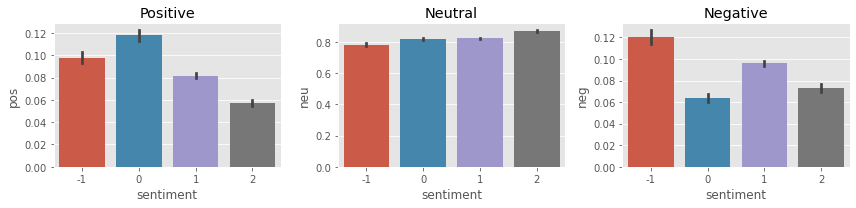

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=vaders, x='sentiment', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='sentiment', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='sentiment', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Twitter-roBERTa-base for Sentiment Analysis 

In [21]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [22]:
#Vader result
print(example)
sia.polarity_scores(example)

Chris: Who is it then that initially talked about climate change?
Me: * thinked for three seconds * ... The EuropeaÃ¢â‚¬Â¦ https://t.co/VwlQICy0H0


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [23]:
def polarity_score_roberta(example):
    #Robert model
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dic = {
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2] 
    }
    #print(scores_dic)
    return scores_dic

In [24]:
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['message']
        myid = row['tweetid']
        results[myid] = sia.polarity_scores(text)
        vader_results = sia.polarity_scores(text)
        vader_results_rename = {}
        for key,val in vader_results.items():
            vader_results_rename[f"vader_{key}"] = val
        roberta_results = polarity_score_roberta(text)
        both = {**vader_results_rename,**roberta_results}
        results[myid] = both
    except RuntimeError:
        print(f'Broke for tweetid{myid}')

  0%|          | 0/15819 [00:00<?, ?it/s]

In [25]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index':'tweetid'})
results_df = results_df.merge(df, how='left')
vaders.head()

,tweetid,neg,neu,pos,compound,sentiment,message
0,625221,0.000,0.905,0.095,0.2244,1,PolySciMajor EPA chief doesn't think carbon di...
1,126103,0.167,0.552,0.281,0.1159,1,It's not like we lack evidence of anthropogeni...
2,698562,0.000,1.000,0.000,0.0000,2,RT @RawStory: Researchers say we have three ye...
3,573736,0.245,0.755,0.000,-0.5994,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
4,466954,0.299,0.701,0.000,-0.7506,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [26]:
results_df.columns

Index(['tweetid', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'sentiment', 'message'],
      dtype='object')

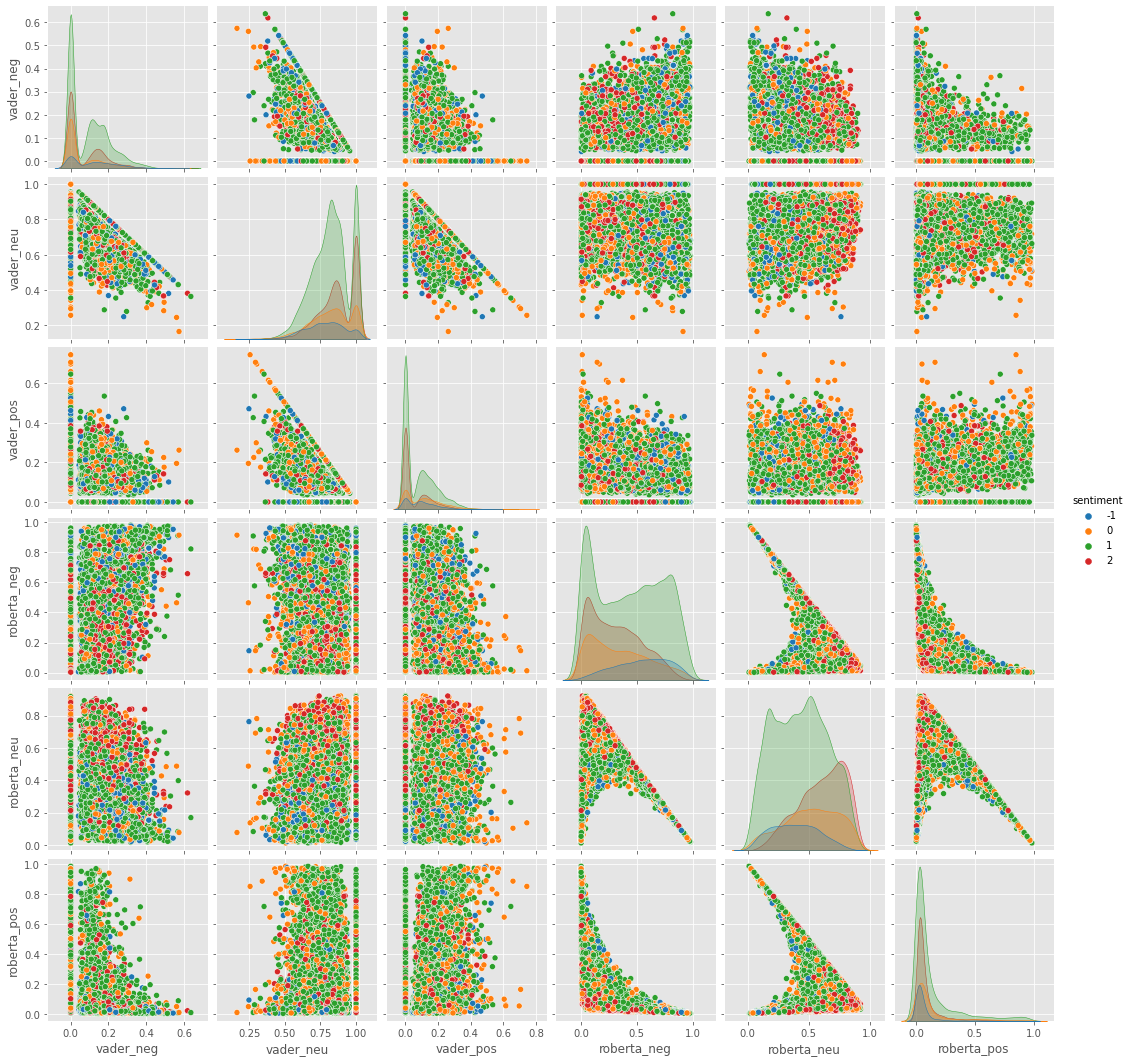

In [27]:
sns.pairplot(data=results_df,
            vars = ['vader_neg','vader_neu','vader_pos','roberta_neg','roberta_neu',
                'roberta_pos'],
            hue='sentiment',
            palette='tab10')
plt.show()

In [28]:
results_df.query('sentiment == -1') \
    .sort_values('roberta_pos', ascending=False)['message'].values[0]

"It's November 5th and I just played a round of golf... I love global warming!"

In [29]:
results_df.query('sentiment == -1') \
    .sort_values('vader_pos', ascending=False)['message'].values[0]

'RT @Martin_Durkin: Wonderful Trump appoints the charming, clever, sane Myron Ebell to take on the global warming charlatans. Hurrah!!! httpÃ¢â‚¬Â¦'

In [30]:
results_df.query('sentiment == 0') \
    .sort_values('roberta_pos', ascending=False)['message'].values[0]

'Ice cream truck in Ohio in February.  I love global warming.  :) https://t.co/lSle77Tclo'

In [31]:
results_df.query('sentiment == 0') \
    .sort_values('vader_pos', ascending=False)['message'].values[0]

'Love global warming. https://t.co/UReox3y7OF'

In [32]:
results_df.query('sentiment == 1') \
    .sort_values('roberta_pos', ascending=False)['message'].values[0]

"Leo's climate change documentary is so epic. He's amazing."

In [33]:
results_df.query('sentiment == 1') \
    .sort_values('vader_pos', ascending=False)['message'].values[0]

"Business opportunities created by climate change.' Interesting"

In [34]:
results_df.query('sentiment == 2') \
    .sort_values('roberta_pos', ascending=False)['message'].values[0]

'RT @The_GA: The 3 minute story of 800,000 years of climate change via \n@ConversationUS - really great video!\nhttps://t.co/oa241AQPXa #geogr…'

In [35]:
results_df.query('sentiment == 2') \
    .sort_values('vader_pos', ascending=False)['message'].values[0]

'Sharks help prevent climate change https://t.co/Jtpcla42Hv'

## The Transformers Pipeline

In [36]:
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [37]:
sent_pipeline('I feel good today')

[{'label': 'POSITIVE', 'score': 0.9998588562011719}]